<h1 align="center" style="color:blue">NYC Taxi Trips EDA -2</h1>

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

<h2 align="center" style="color:blue">Data Loading</h2>

In [ ]:
df = pd.read_parquet('tripdata_march25.parquet')
df.shape

In [4]:
columns_to_drop = ['dispatching_base_num', 'originating_base_num', 'on_scene_datetime','trip_time', 'bcf', 'sales_tax','shared_request_flag', 
                   'shared_match_flag', 'access_a_ride_flag','wav_request_flag', 'wav_match_flag']

df = df.drop(columns=columns_to_drop)
df.shape

(20536879, 14)

<h2 align="center" style="color:blue">New Columns</h2>

### Creating Congestion fee column

In [7]:
df["total_congestion"] = df["congestion_surcharge"] + df["cbd_congestion_fee"]

In [9]:
columns_to_drop = ['congestion_surcharge','cbd_congestion_fee']

df = df.drop(columns=columns_to_drop)
df.shape

(20536879, 13)

### Creating Service provider column

In [11]:
df["hvfhs_license_num"].value_counts(normalize=True)

hvfhs_license_num
HV0003    0.708344
HV0005    0.291656
Name: proportion, dtype: float64

In [13]:
df["hvfhs_license_num"] = df["hvfhs_license_num"].replace({
    "HV0003": "Uber",
    "HV0005": "Lyft"})

In [15]:
df = df.rename(columns={"hvfhs_license_num": "service_provider"})
df.shape

(20536879, 13)

### Creating Trip Time Column

In [17]:
df['trip_time'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
df.shape

(20536879, 14)

<h2 align="center" style="color:blue">Filtering Extreme Values</h2>

### Setting thresholds for base_passenger_fare

In [19]:
df = df[df['base_passenger_fare']<120]

In [21]:
df = df[df["base_passenger_fare"]>1]

### Setting thresholds for trip distance

In [23]:
df = df[df['trip_miles']>0]

In [25]:
df = df[df['trip_miles']<26.94]

In [27]:
df = df[df['trip_miles']>0.06]

### Setting thresholds for trip time

In [29]:
df = df[df["trip_time"]<170]

In [31]:
df = df[df["trip_time"]>2]

### Filtering unusual values from driver_pay 

In [33]:
df = df[df['driver_pay'] > 0]

### Filtering unusual datetime values

In [35]:
df = df[df['request_datetime'] <= df['pickup_datetime']]

### Creating pickup_hour, day_name and day_type (Weekend/Weekday column)

In [37]:
df['pickup_hour'] = df['pickup_datetime'].dt.hour

In [39]:
df['pickup_day'] = df['pickup_datetime'].dt.day_name()

In [41]:
df['day_type'] = df['pickup_day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

In [61]:
df['day_type'].unique()

array(['Weekend', 'Weekday'], dtype=object)

<h2 align="center" style="color:blue">Trip Distance, Avg Fare vs Hour</h2>

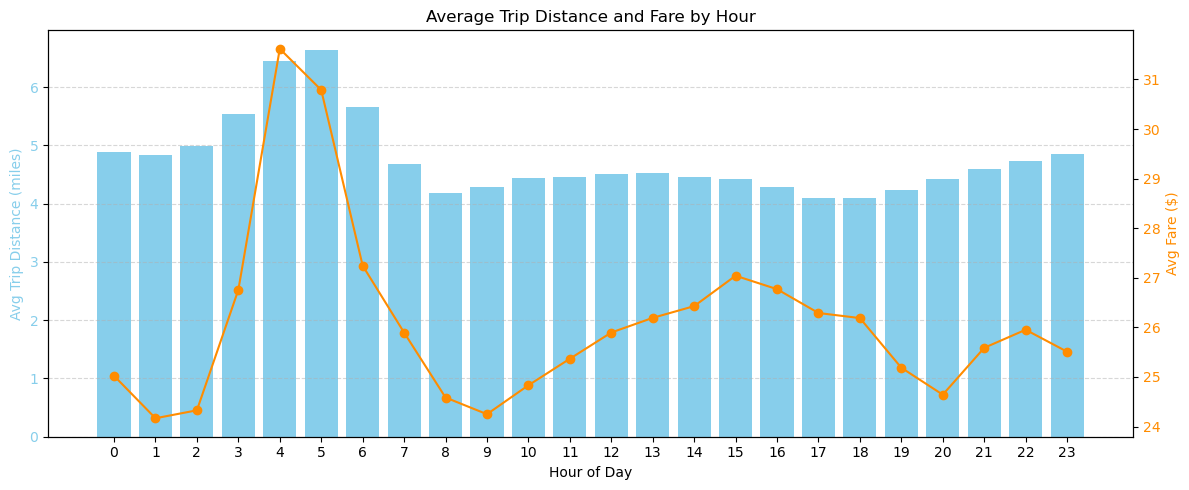

In [46]:
hourly_stats = df.groupby('pickup_hour').agg({
    'trip_miles': 'mean',
    'base_passenger_fare': 'mean'
})

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Bar chart for average trip miles
ax1.bar(hourly_stats.index, hourly_stats['trip_miles'], color='skyblue', label='Avg Trip Distance')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Avg Trip Distance (miles)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Line chart for average fare on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(hourly_stats.index, hourly_stats['base_passenger_fare'], color='darkorange', marker='o', label='Avg Fare')
ax2.set_ylabel('Avg Fare ($)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Title and layout
plt.title('Average Trip Distance and Fare by Hour')
fig.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Calculate Hour-to-Hour Growth in Trip Volume, Avg Fare</h2>

In [48]:
df_volume = df.groupby('pickup_hour').size()

# Convert trip volume to percentage change hour-to-hour
volume_change_pct = df_volume.pct_change() * 100  # Percent change from previous hour

# Create a DataFrame with volume and % change
volume_change_df = pd.DataFrame({
    'Trip Volume': df_volume,
    'Hourly % Change': volume_change_pct
})

# Top 3 increases in trip volume
top3_volume_increases = volume_change_df['Hourly % Change'].nlargest(3)
print("Top 3 Increases in Trip Volume (%):")
print(top3_volume_increases)

# Top 3 decreases in trip volume
top3_volume_decreases = volume_change_df['Hourly % Change'].nsmallest(3)
print("\nTop 3 Decreases in Trip Volume (%):")
print(top3_volume_decreases)

Top 3 Increases in Trip Volume (%):
pickup_hour
6    60.871854
7    52.817689
8    23.276422
Name: Hourly % Change, dtype: float64

Top 3 Decreases in Trip Volume (%):
pickup_hour
2   -33.066473
1   -30.226177
3   -14.792780
Name: Hourly % Change, dtype: float64


In [50]:
avg_fare = df.groupby('pickup_hour')['base_passenger_fare'].mean()

# Step 2: Calculate hour-to-hour percentage change
fare_change_pct = avg_fare.pct_change() * 100  # Convert to percent

# Step 3: Create a DataFrame with both avg fare and % change
fare_change_df = pd.DataFrame({
    'Avg Fare': avg_fare,
    'Hourly % Change': fare_change_pct
})

# Step 4: Top 3 increases
top3_increases = fare_change_df['Hourly % Change'].nlargest(3)
print("Top 3 Increases in Avg Fare (%):")
print(top3_increases)

# Step 5: Top 3 decreases
top3_decreases = fare_change_df['Hourly % Change'].nsmallest(3)
print("\nTop 3 Decreases in Avg Fare (%):")
print(top3_decreases)

Top 3 Increases in Avg Fare (%):
pickup_hour
4     18.171130
3      9.988352
21     3.834869
Name: Hourly % Change, dtype: float64

Top 3 Decreases in Avg Fare (%):
pickup_hour
6   -11.511018
8    -5.058631
7    -4.953188
Name: Hourly % Change, dtype: float64


<h2 align="center" style="color:blue">Location Lookup Table</h2>

### Importing location_lookup table and removing duplicate records

In [27]:
location_lookup = pd.read_csv("Location_lookup.csv")
location_lookup.shape

(260, 3)

In [9]:
location_lookup.duplicated().sum()

0

In [11]:
zone_id_counts = location_lookup.groupby('Zone')['LocationID'].nunique()

# Step 2: Filter to zones with more than one LocationID
duplicate_zones = zone_id_counts[zone_id_counts > 1]

print(duplicate_zones)

Zone
Corona                                           2
Governor's Island/Ellis Island/Liberty Island    3
Name: LocationID, dtype: int64


In [21]:
location_lookup = location_lookup.drop_duplicates(subset='Zone', keep='first').reset_index(drop=True)

In [25]:
location_lookup.to_csv('Location_lookup.csv', index=False)

### Joining location_lookup with the main trip dataset to get readable Zone and Borough names

In [91]:
# Merge Pickup Zone and Borough
df = df.merge(
    location_lookup[['LocationID', 'Zone', 'Borough']].rename(
        columns={'LocationID': 'PULocationID', 'Zone': 'PU_Zone', 'Borough': 'PU_Borough'}
    ),
    on='PULocationID',
    how='left'
)

# Merge Drop-off Zone and Borough
df = df.merge(
    location_lookup[['LocationID', 'Zone', 'Borough']].rename(
        columns={'LocationID': 'DOLocationID', 'Zone': 'DO_Zone', 'Borough': 'DO_Borough'}
    ),
    on='DOLocationID',
    how='left'
)

I am doing:

PULocationID → LocationID → PU_Zone, PU_Borough

DOLocationID → LocationID → DO_Zone, DO_Borough

You do need two merges — because PULocationID and DOLocationID are two different columns referring to the same dimension (LocationID).

<h2 align="center" style="color:blue">Hourly Fare of Top 5 pickup Zones</h2>

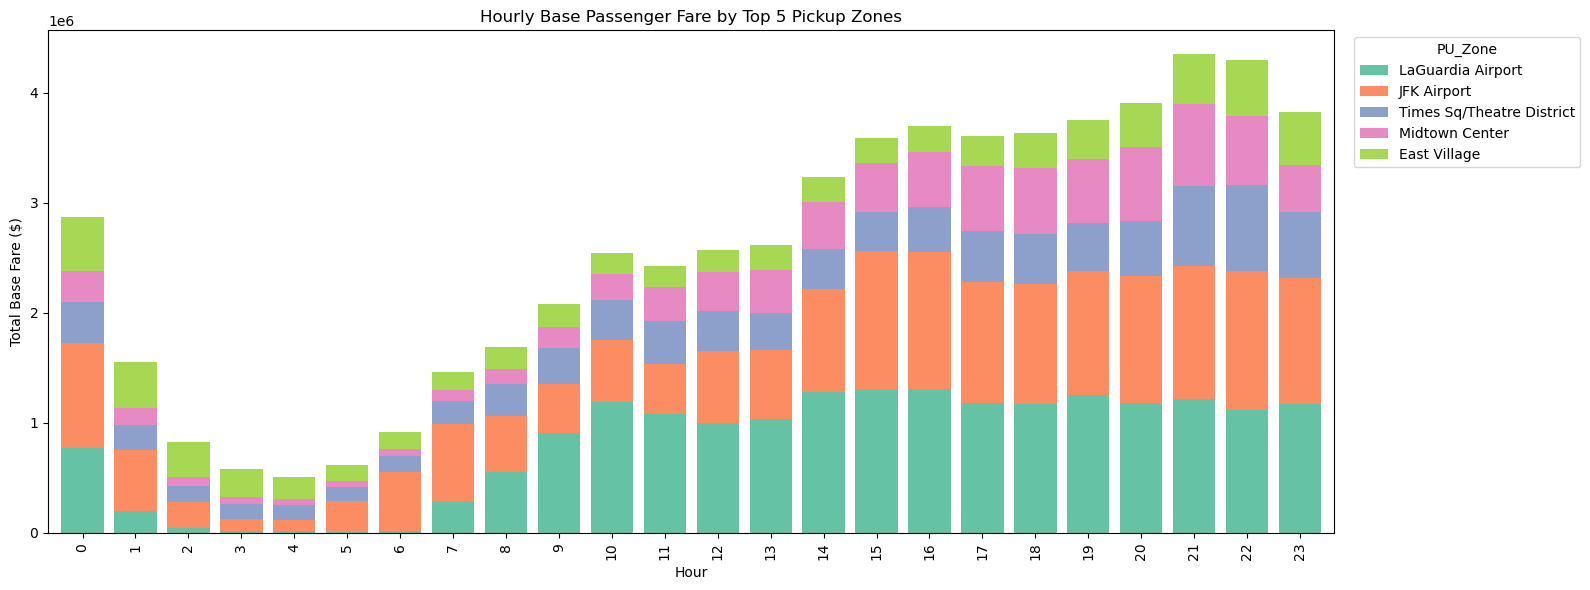

In [105]:
hourly_fare = df.groupby(['pickup_hour', 'PU_Zone'])['base_passenger_fare'].sum().reset_index()

# Get top 5 zones by total fare
top_zones = (df.groupby('PU_Zone')['base_passenger_fare']
               .sum()
               .sort_values(ascending=False)
               .head(5)
               .index.tolist())

# Filter and pivot
hourly_fare_top = hourly_fare[hourly_fare['PU_Zone'].isin(top_zones)]
pivot_df = hourly_fare_top.pivot(index='pickup_hour', columns='PU_Zone', values='base_passenger_fare').fillna(0)

# Sort columns by total revenue (descending)
pivot_df = pivot_df[top_zones]

# Use Set2 palette
colors = sns.color_palette("Set2", n_colors=len(top_zones))

# Plot stacked bar chart
pivot_df.plot(kind='bar', stacked=True, figsize=(16, 6), width=0.8, color=colors)

plt.title('Hourly Base Passenger Fare by Top 5 Pickup Zones')
plt.xlabel('Hour')
plt.ylabel('Total Base Fare ($)')
plt.legend(title='PU_Zone', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Congestion Fare vs Trip time in Manhattan Borough</h2>

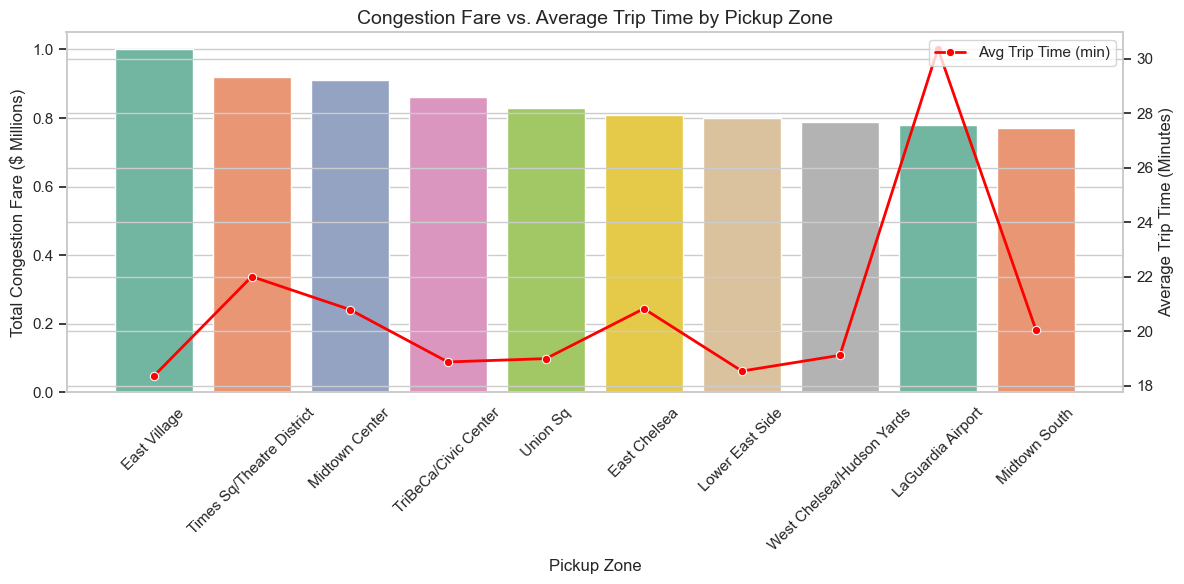

In [145]:
zone_stats = (
    df.groupby('PU_Zone')
      .agg(
          total_congestion=('total_congestion', 'sum'),
          avg_trip_time=('trip_time', 'mean')
      )
      .sort_values(by='total_congestion', ascending=False)
      .head(10)
      .reset_index()
)

# Step 2: Convert congestion fare to millions
zone_stats['congestion_million'] = (zone_stats['total_congestion'] / 1_000_000).round(2)

# Step 3: Plot combo chart
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for congestion fare
sns.barplot(
    x='PU_Zone',
    y='congestion_million',
    data=zone_stats,
    palette='Set2',
    ax=ax1
)
ax1.set_ylabel('Total Congestion Fare ($ Millions)', fontsize=12)
ax1.set_xlabel('Pickup Zone', fontsize=12)
ax1.tick_params(axis='x', rotation=45)

# Line chart for average trip time (on secondary axis)
ax2 = ax1.twinx()
sns.lineplot(
    x='PU_Zone',
    y='avg_trip_time',
    data=zone_stats,
    color='red',
    marker='o',
    linewidth=2,
    label='Avg Trip Time (min)',
    ax=ax2
)
ax2.set_ylabel('Average Trip Time (Minutes)', fontsize=12)
ax2.legend(loc='upper right')

plt.title('Congestion Fare vs. Average Trip Time by Pickup Zone', fontsize=14)
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Average Congestion Fare by Pickup hour</h2>

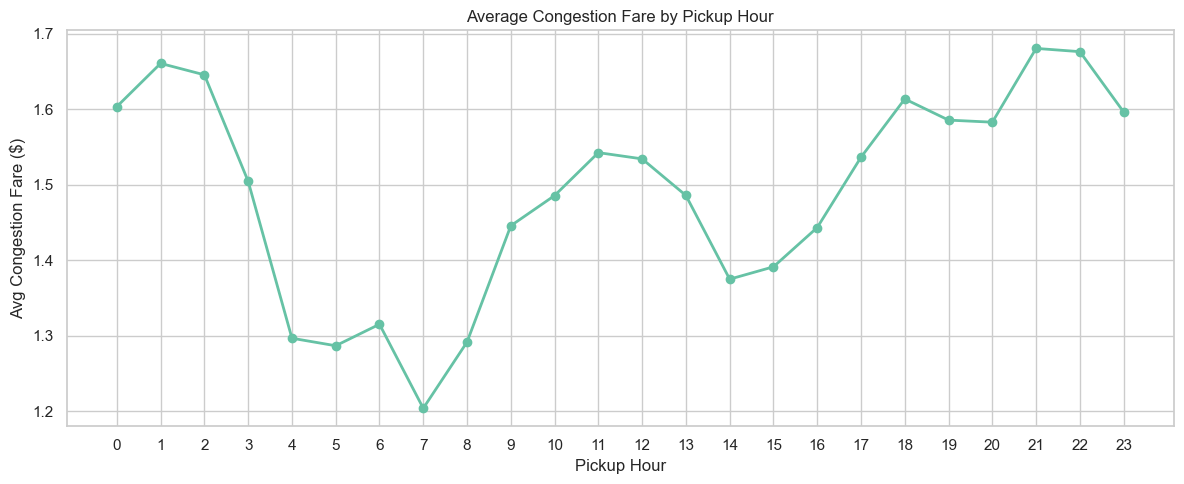

In [173]:
sns.set(style="whitegrid")
set2_color = sns.color_palette("Set2")[0]  # Pick one Set2 color

# Plot: Average congestion by pickup hour
plt.figure(figsize=(12, 5))  # Wider figure
df.groupby('pickup_hour')['total_congestion'].mean().plot(
    kind='line',
    color=set2_color,
    marker='o',
    linewidth=2
)

# Labels and title
plt.title('Average Congestion Fare by Pickup Hour')
plt.xlabel('Pickup Hour')
plt.ylabel('Avg Congestion Fare ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


<h2 align="center" style="color:blue">Airport Trips Volume, Avg Fare by Pickup hour</h2>

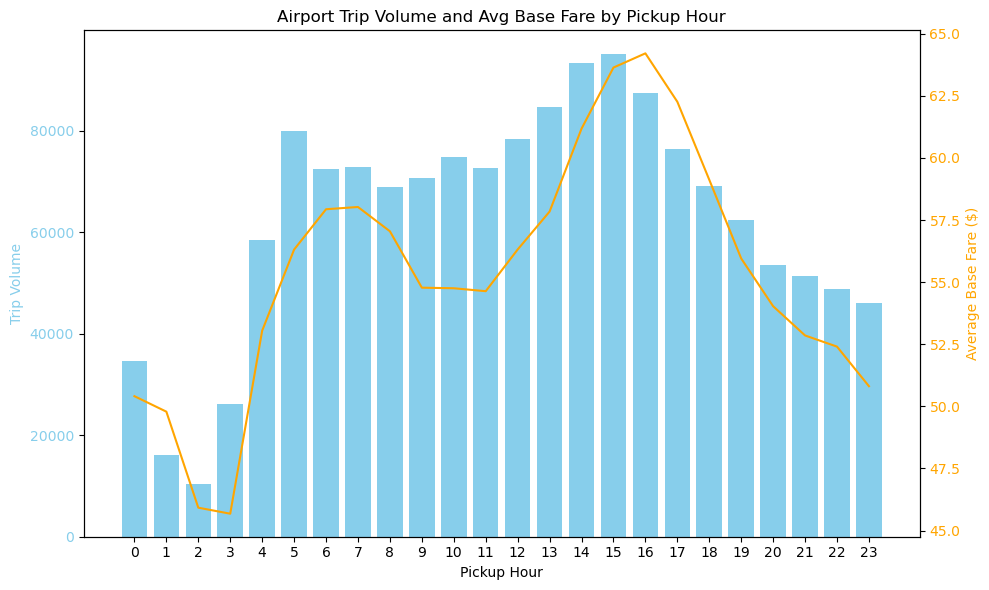

In [43]:
airport_trips = df[df['airport_fee'] > 0]

# Ensure pickup_hour is available (if not, create it from a datetime column like 'pickup_datetime')
if 'pickup_hour' not in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])  # adjust column name if different
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    airport_trips = df[df['airport_fee'] > 0]

# Group by pickup hour for airport trip volume
trip_volume_by_hour = airport_trips.groupby('pickup_hour').size()

# Group by pickup hour for average base fare
avg_fare_by_hour = airport_trips.groupby('pickup_hour')['base_passenger_fare'].mean()
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for trip volume
ax1.bar(trip_volume_by_hour.index, trip_volume_by_hour.values, color='skyblue', label='Airport Trip Volume')
ax1.set_xlabel('Pickup Hour')
ax1.set_ylabel('Trip Volume', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

# Line plot for average base fare
ax2 = ax1.twinx()
ax2.plot(avg_fare_by_hour.index, avg_fare_by_hour.values, color='orange', label='Average Base Fare')
ax2.set_ylabel('Average Base Fare ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Airport Trip Volume and Avg Base Fare by Pickup Hour')
plt.xticks(range(0, 24))
fig.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Airport Trips Distance, Avg Fare by Pickup hour</h2>

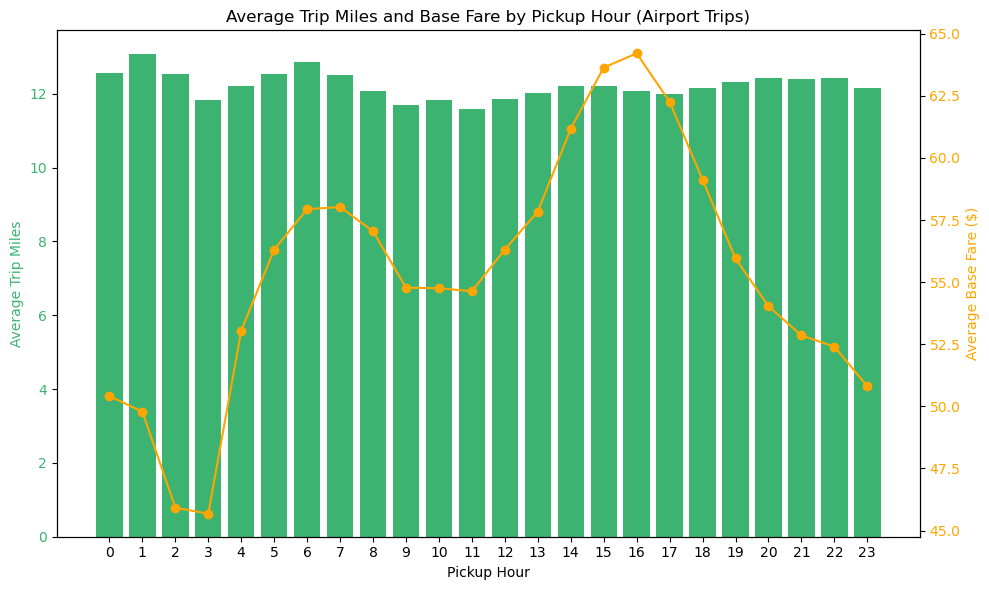

In [53]:
airport_trips = airport_trips[airport_trips['trip_miles'].notnull() & (airport_trips['trip_miles'] > 0)]

# Group by pickup hour
avg_trip_miles_by_hour = airport_trips.groupby('pickup_hour')['trip_miles'].mean()
avg_base_fare_by_hour = airport_trips.groupby('pickup_hour')['base_passenger_fare'].mean()
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for average trip miles
ax1.bar(avg_trip_miles_by_hour.index, avg_trip_miles_by_hour.values, color='mediumseagreen', label='Avg Trip Miles')
ax1.set_xlabel('Pickup Hour')
ax1.set_ylabel('Average Trip Miles', color='mediumseagreen')
ax1.tick_params(axis='y', labelcolor='mediumseagreen')
ax1.set_xticks(range(24))

# Line chart for average base fare
ax2 = ax1.twinx()
ax2.plot(avg_base_fare_by_hour.index, avg_base_fare_by_hour.values, color='orange', marker='o', label='Avg Base Fare')
ax2.set_ylabel('Average Base Fare ($)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Average Trip Miles and Base Fare by Pickup Hour (Airport Trips)')
fig.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Congestion : Weekend vs Weekday</h2>

In [177]:
df['day_type'] = df['pickup_day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

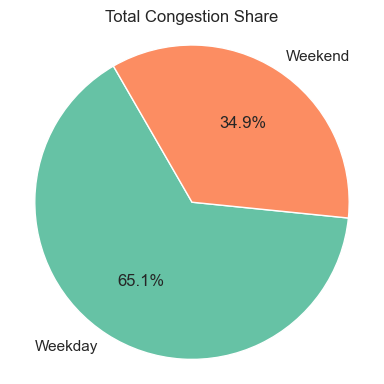

In [193]:
congestion_by_daytype = df.groupby('day_type')['total_congestion'].sum()

# Plot pie chart
colors = ['#66c2a5', '#fc8d62']  # Set2 palette colors
plt.figure(figsize=(4, 4))
plt.pie(congestion_by_daytype, labels=congestion_by_daytype.index, autopct='%1.1f%%', startangle=120, colors=colors)
plt.title('Total Congestion Share')
plt.axis('equal')  # Equal aspect ratio ensures pie is circular
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Saturday Trip Volume</h2>

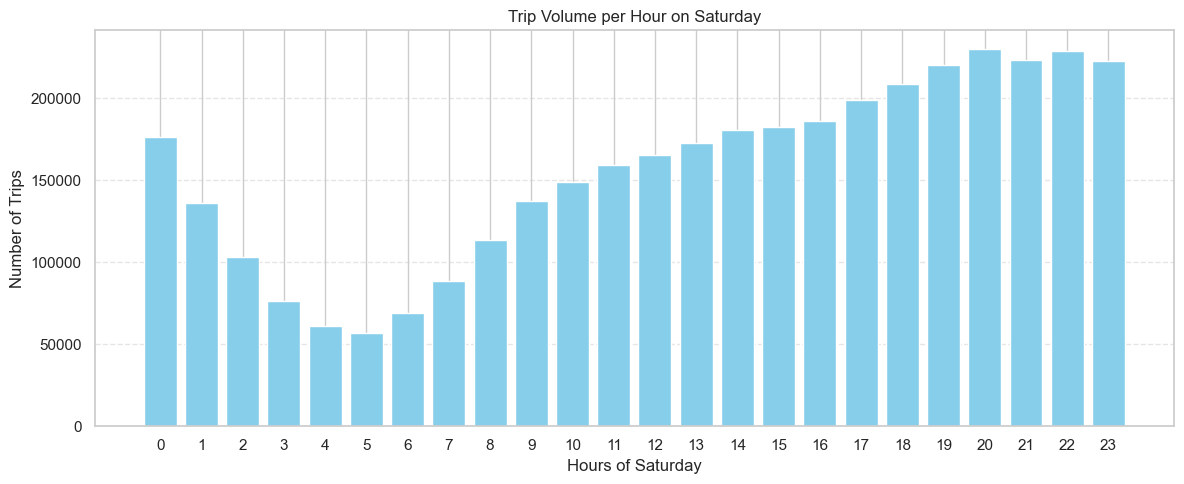

In [201]:
sat_data = df[df['pickup_day'] == 'Saturday']
sat_trip_volume = sat_data.groupby('pickup_hour').size()

plt.figure(figsize=(12, 5))
plt.bar(sat_trip_volume.index, sat_trip_volume.values, color='skyblue')
plt.title('Trip Volume per Hour on Saturday')
plt.xlabel('Hours of Saturday')
plt.ylabel('Number of Trips')
plt.xticks(range(24))  # Ensure all hours are shown
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Thursday Trips</h2>

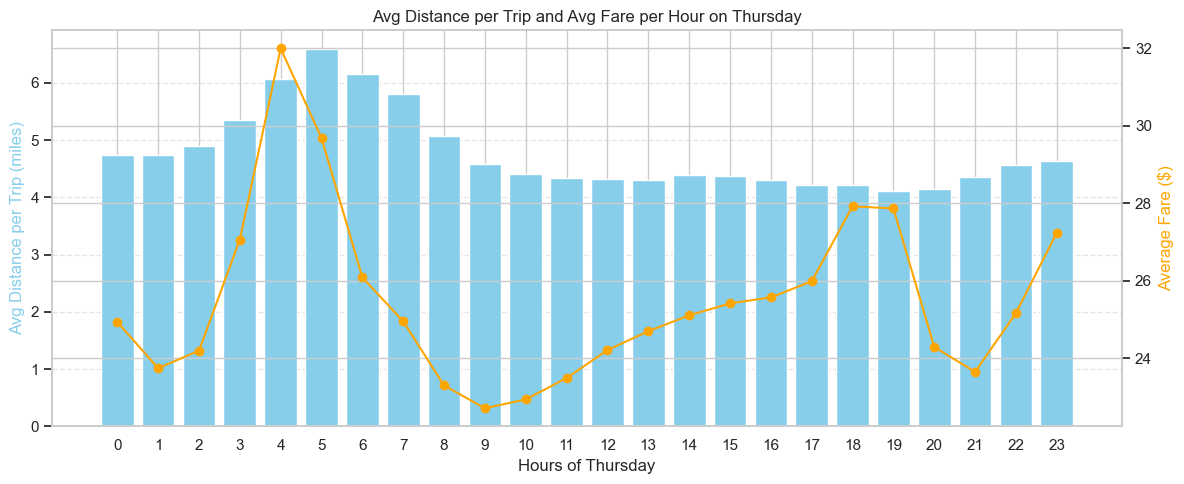

In [203]:
thurs_data = df[df['pickup_day'] == 'Thursday']

# Group by hour
trip_count = sat_data.groupby('pickup_hour').size()
trip_miles = sat_data.groupby('pickup_hour')['trip_miles'].sum()
avg_fare = sat_data.groupby('pickup_hour')['base_passenger_fare'].mean()

# Calculate average distance per trip
avg_distance = trip_miles / trip_count

# Plot
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 5))

# Bar plot: average distance per trip
ax1.bar(avg_distance.index, avg_distance.values, color='skyblue', label='Avg Distance per Trip')
ax1.set_xlabel('Hours of Thursday')
ax1.set_ylabel('Avg Distance per Trip (miles)', color='skyblue')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Line plot: average fare
ax2 = ax1.twinx()
ax2.plot(avg_fare.index, avg_fare.values, color='orange', marker='o', label='Avg Fare ($)')
ax2.set_ylabel('Average Fare ($)', color='orange')

plt.title('Avg Distance per Trip and Avg Fare per Hour on Thursday')
fig.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Manhattan Trips</h2>

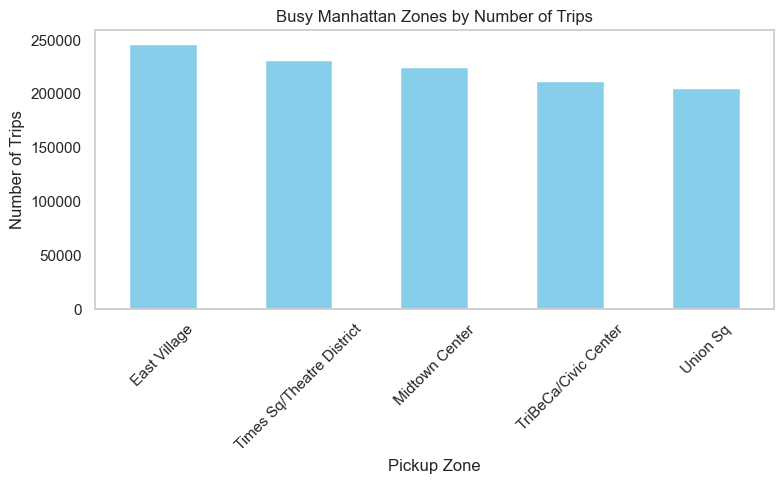

In [217]:
manhattan_trips = df[df['PU_Borough'] == 'Manhattan']

# Count trips by PU_Zone and get top 10
top10_manhattan_zones = manhattan_trips['PU_Zone'].value_counts().head(5)

# Plot vertical bar chart
top10_manhattan_zones.plot(
    kind='bar',
    color='skyblue',
    figsize=(8, 5)
)

plt.title('Busy Manhattan Zones by Number of Trips')
plt.xlabel('Pickup Zone')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)  
plt.grid(False)  
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Tolls Weekday vs Weekend</h2>

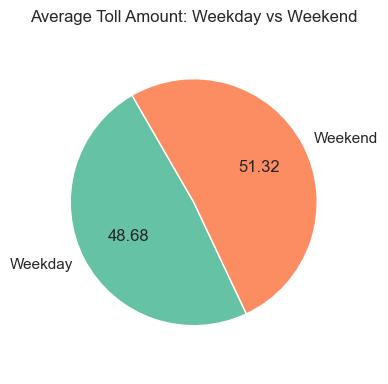

In [215]:
avg_tolls = df.groupby('day_type')['tolls'].mean()

# Get Set2 palette colors
colors = sns.color_palette("Set2")[0:2]  # Just need two colors

# Plot pie chart
plt.figure(figsize=(4, 4))
plt.pie(
    avg_tolls, 
    labels=avg_tolls.index, 
    autopct='%1.2f', 
    startangle=120, 
    colors=colors
)
plt.title('Average Toll Amount: Weekday vs Weekend')
plt.axis('equal')  # Ensures the pie is circular
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Driver Pay (Weekday vs Weekend)</h2>

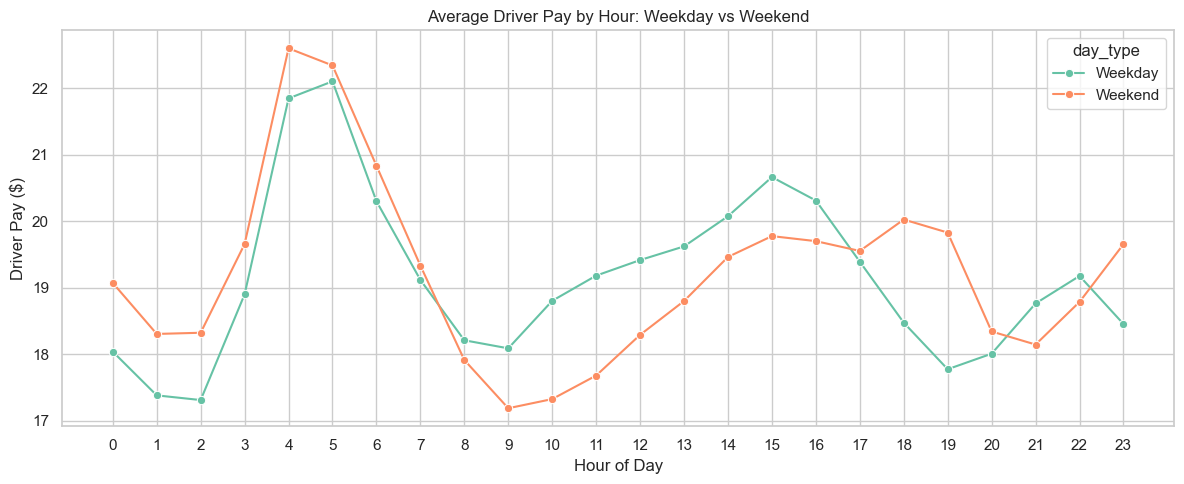

In [223]:
hourly_stats = df.groupby(['pickup_hour', 'day_type'])[['driver_pay', 'tips']].mean().reset_index()

# Set style and palette
sns.set(style="whitegrid", palette="Set2")

# -------- Plot 1: Driver Pay --------
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=hourly_stats, 
    x='pickup_hour', 
    y='driver_pay', 
    hue='day_type', 
    marker='o'
)
plt.title('Average Driver Pay by Hour: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Driver Pay ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Tips (Weekday vs Weekend)</h2>

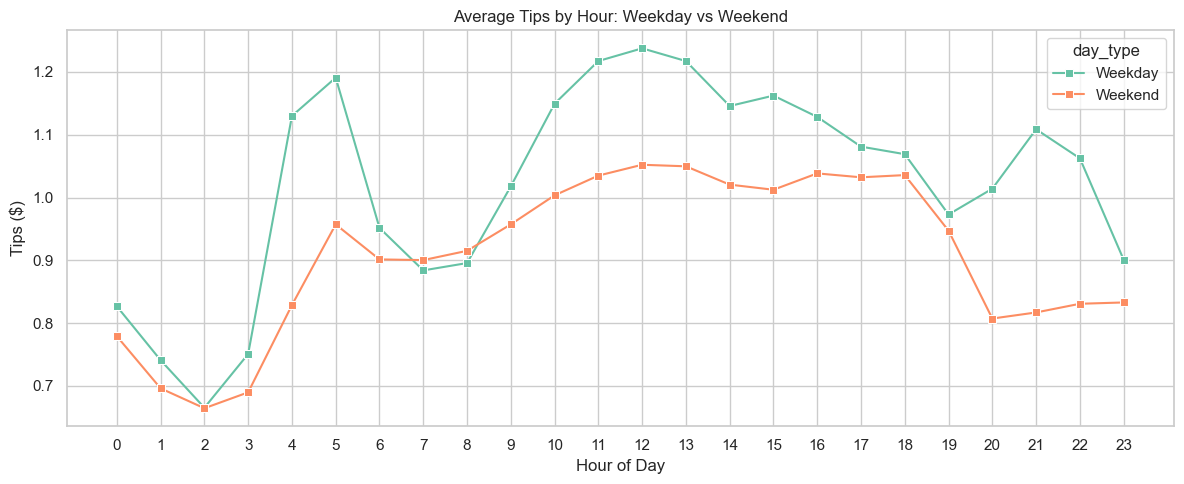

In [225]:
plt.figure(figsize=(12, 5))
sns.lineplot(
    data=hourly_stats, 
    x='pickup_hour', 
    y='tips', 
    hue='day_type', 
    marker='s'
)
plt.title('Average Tips by Hour: Weekday vs Weekend')
plt.xlabel('Hour of Day')
plt.ylabel('Tips ($)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Hourly Trip Volume in a week</h2>

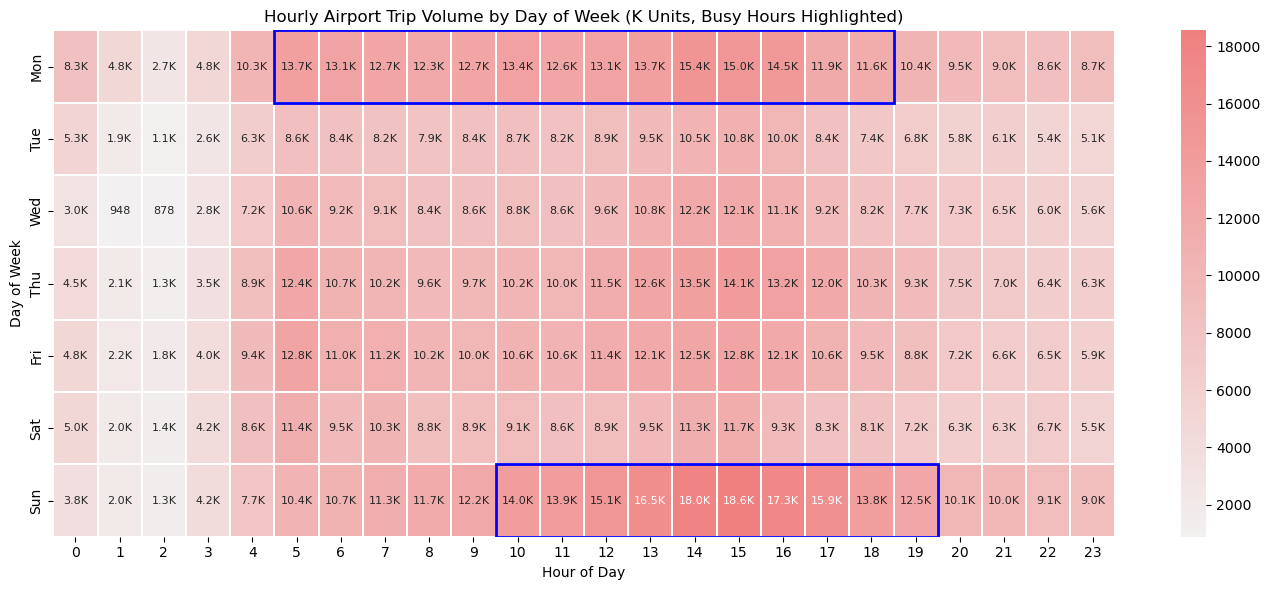

In [71]:
import matplotlib.patches as patches

air_trips = df[df["airport_fee"] > 0].copy()

# Map day numbers to names
day_map = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
air_trips['pickup_day_name'] = air_trips['pickup_day'].map(day_map)

# Group and reshape for heatmap
heatmap_data = air_trips.groupby(['pickup_day_name', 'pickup_hour']).size().unstack().fillna(0)

# Reorder days of week
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
heatmap_data = heatmap_data.reindex(day_order)

# Create annotation labels in thousands
annot_data = heatmap_data.applymap(lambda x: f"{x/1000:.1f}K" if x >= 1000 else f"{int(x)}")

# Plot heatmap
plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    heatmap_data,
    cmap=sns.light_palette("lightcoral", as_cmap=True),
    linewidths=0.3,
    linecolor='white',
    annot=annot_data,
    fmt="",
    annot_kws={"size": 8},
    cbar=True
)

# Draw boxes around key busy periods

day_to_y = {day: i for i, day in enumerate(day_order)}

# Sunday 10 AM – 7 PM (hour 10 to 19)
y_sun = day_to_y['Sun']
ax.add_patch(patches.Rectangle((10, y_sun), 10, 1, fill=False, edgecolor='blue', lw=2))

# Monday 5 AM – 6 PM (hour 5 to 18)
y_mon = day_to_y['Mon']
ax.add_patch(patches.Rectangle((5, y_mon), 14, 1, fill=False, edgecolor='blue', lw=2))

# Final formatting
plt.title('Hourly Airport Trip Volume by Day of Week (K Units, Busy Hours Highlighted)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Airport Trips (Monday)</h2>

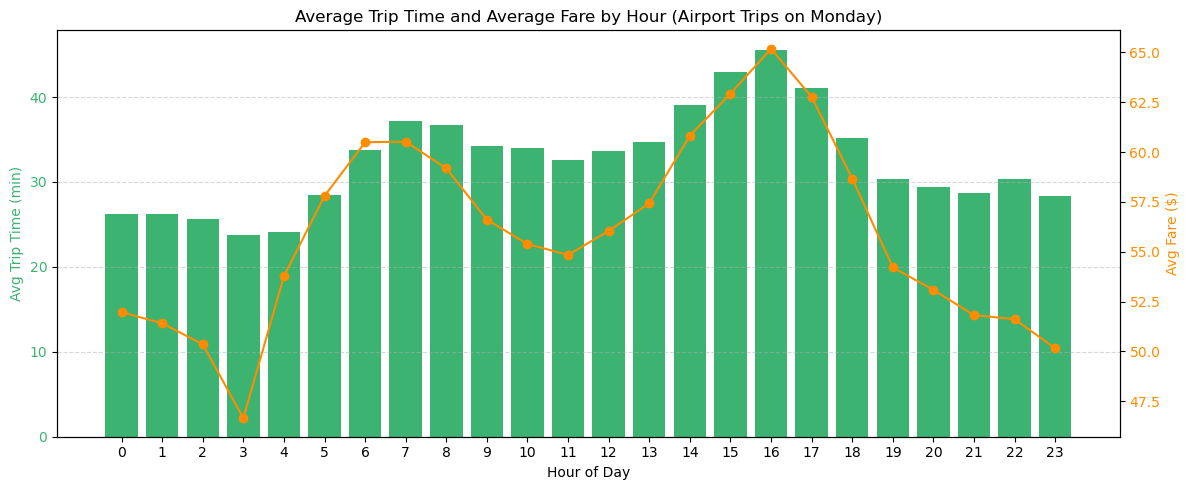

In [85]:
monday_airport_trips = df[(df['airport_fee'] > 0) & (df['pickup_day'] == 0)]

# Group by hour: average trip_time and average fare
hourly_stats = monday_airport_trips.groupby('pickup_hour').agg({
    'trip_time': 'mean',
    'base_passenger_fare': 'mean'
})

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Bar chart for average trip time
ax1.bar(hourly_stats.index, hourly_stats['trip_time'], color='mediumseagreen', label='Avg Trip Time (min)')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Avg Trip Time (min)', color='mediumseagreen')
ax1.tick_params(axis='y', labelcolor='mediumseagreen')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Line chart for average fare
ax2 = ax1.twinx()
ax2.plot(hourly_stats.index, hourly_stats['base_passenger_fare'], color='darkorange', marker='o', label='Avg Fare')
ax2.set_ylabel('Avg Fare ($)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Title and layout
plt.title('Average Trip Time and Average Fare by Hour (Airport Trips on Monday)')
fig.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Exploring Congestions in Manhattan</h2>

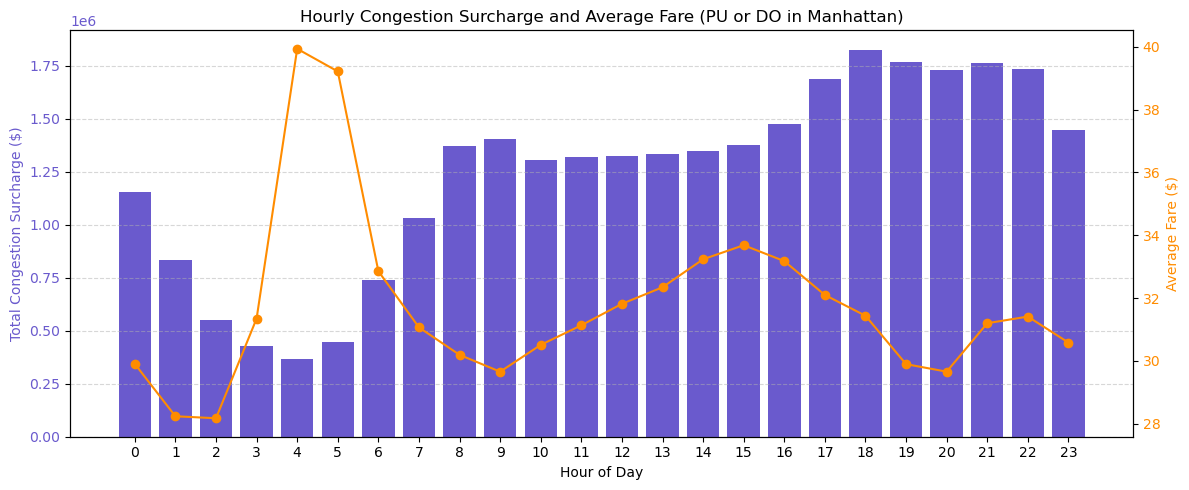

In [95]:
manhattan_trips = df[(df['PU_Borough'] == 'Manhattan') | (df['DO_Borough'] == 'Manhattan')].copy()

# Group by hour: sum of congestion surcharge and mean base fare
hourly_stats = manhattan_trips.groupby('pickup_hour').agg({
    'total_congestion': 'sum',
    'base_passenger_fare': 'mean'
}).rename(columns={'total_congestion': 'total_congestion_surcharge'})

# Plot
fig, ax1 = plt.subplots(figsize=(12, 5))

# Bar chart for total congestion surcharge
ax1.bar(hourly_stats.index, hourly_stats['total_congestion_surcharge'], color='slateblue', label='Total Congestion Surcharge')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Total Congestion Surcharge ($)', color='slateblue')
ax1.tick_params(axis='y', labelcolor='slateblue')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Line chart for average fare
ax2 = ax1.twinx()
ax2.plot(hourly_stats.index, hourly_stats['base_passenger_fare'], color='darkorange', marker='o', label='Avg Fare')
ax2.set_ylabel('Average Fare ($)', color='darkorange')
ax2.tick_params(axis='y', labelcolor='darkorange')

# Title and layout
plt.title('Hourly Congestion Surcharge and Average Fare (PU or DO in Manhattan)')
fig.tight_layout()
plt.show()

In [ ]:
speed = trip_miles / (trip_time / 60)

Lower speed → higher congestion

<h2 align="center" style="color:blue">Avg Trip Speed in Manhattan by Hour</h2>

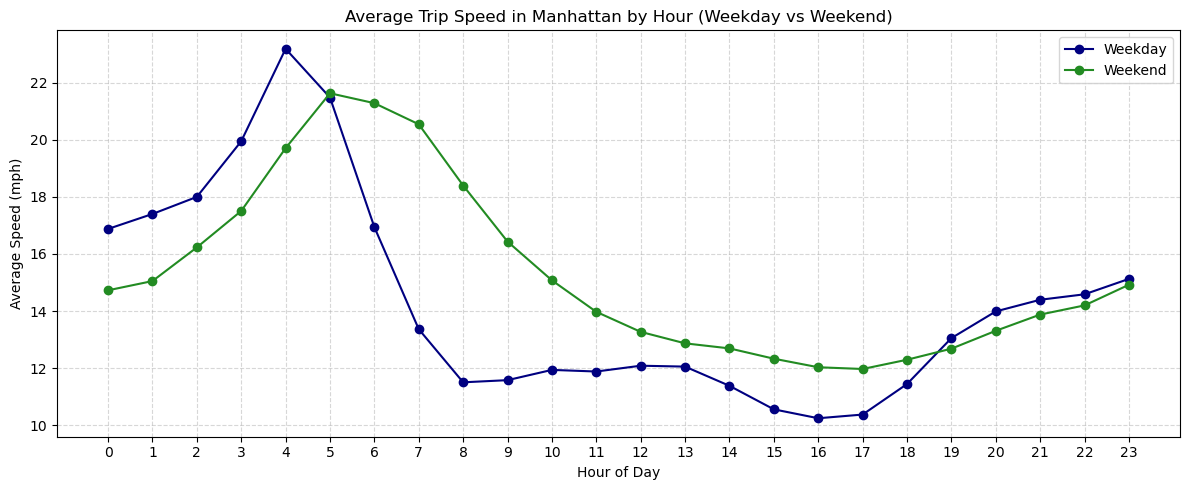

In [99]:
manhattan_trips = df[
    ((df['PU_Borough'] == 'Manhattan') | (df['DO_Borough'] == 'Manhattan')) &
    (df['trip_time'] > 0) & (df['trip_miles'] > 0)
].copy()

# Extract pickup hour and weekday flag
manhattan_trips['pickup_hour'] = manhattan_trips['pickup_datetime'].dt.hour
manhattan_trips['pickup_day'] = manhattan_trips['pickup_datetime'].dt.dayofweek
manhattan_trips['is_weekend'] = manhattan_trips['pickup_day'] >= 5  # 5 = Saturday, 6 = Sunday

# Compute speed in mph
manhattan_trips['speed_mph'] = manhattan_trips['trip_miles'] / (manhattan_trips['trip_time'] / 60)

# Group by hour and is_weekend
avg_speed = manhattan_trips.groupby(['pickup_hour', 'is_weekend'])['speed_mph'].mean().unstack()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(avg_speed.index, avg_speed[False], label='Weekday', color='navy', marker='o')
plt.plot(avg_speed.index, avg_speed[True], label='Weekend', color='forestgreen', marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Average Speed (mph)')
plt.title('Average Trip Speed in Manhattan by Hour (Weekday vs Weekend)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(24))
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Trip Volume by Borough</h2>

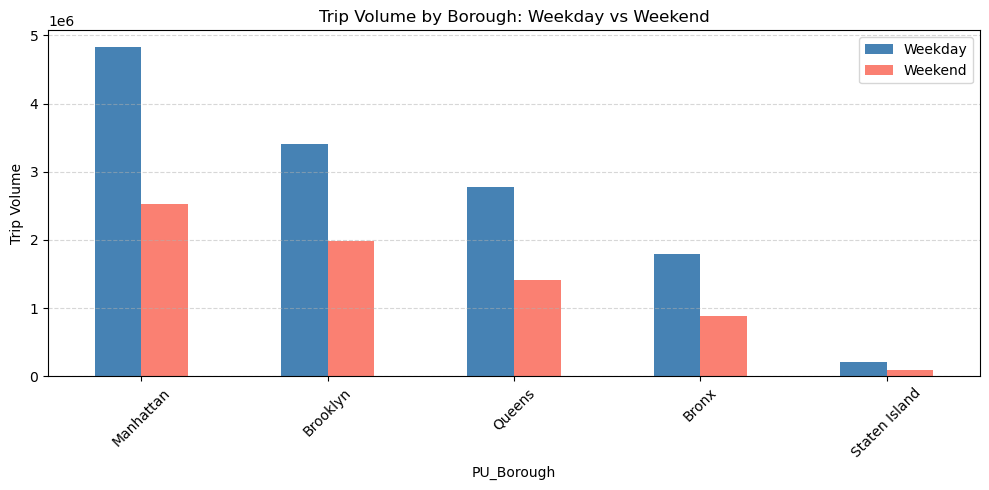

In [101]:
df['pickup_day'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['pickup_day'] >= 5  # Saturday & Sunday = weekend

# Group by pickup borough and weekday/weekend
trip_counts = df.groupby(['PU_Borough', 'is_weekend'])['pickup_datetime'].count().unstack().fillna(0)
trip_counts.columns = ['Weekday', 'Weekend']

# Plot
trip_counts.sort_values('Weekday', ascending=False).plot(
    kind='bar',
    figsize=(10, 5),
    color=['steelblue', 'salmon']
)
plt.ylabel('Trip Volume')
plt.title('Trip Volume by Borough: Weekday vs Weekend')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

<h2 align="center" style="color:blue">Brooklyn Trips</h2>

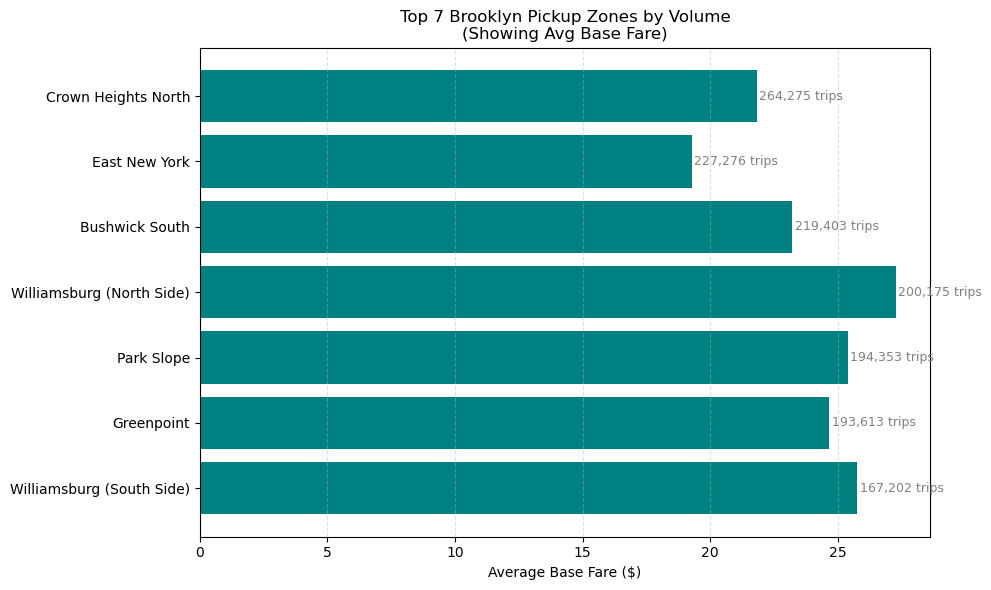

In [107]:
brooklyn_trips = df[df['PU_Borough'] == 'Brooklyn'].copy()

# Group by pickup location (assumed to be PU_Zone or similar)
location_group = brooklyn_trips.groupby('PU_Zone').agg({
    'pickup_datetime': 'count',
    'base_passenger_fare': 'mean'
}).rename(columns={'pickup_datetime': 'trip_volume'})

# Get top 7 by trip volume
top7 = location_group.sort_values('trip_volume', ascending=False).head(7)

# Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(top7.index[::-1], top7['base_passenger_fare'][::-1], color='teal')  # reverse for highest on top
plt.xlabel('Average Base Fare ($)')
plt.title('Top 7 Brooklyn Pickup Zones by Volume\n(Showing Avg Base Fare)')
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate bars with volume info (optional)
for bar, volume in zip(bars, top7['trip_volume'][::-1]):
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height() / 2,
             f'{volume:,} trips', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()